In [1]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

2022-04-06 19:09:48.183620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 19:09:48.183640: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Loading the relevant datasets (15/100)

In [ ]:
# specify the model input with the required shape 
# (1)
in_shape = keras.Input(shape=(256, 256, 1))

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# TODO

leaky_relu = tf.keras.layers.LeakyReLU()
reg = tf.keras.regularizers.l2(l2=0.0001)

layer1 = tf.keras.layers.Conv2D(8, (3,3), name="layer1")
layer2 = tf.keras.layers.MaxPool2D(3,3, name="layer2")
layer3 = tf.keras.layers.Flatten(name="layer3")
layer4 = tf.keras.layers.Normalization(name="layer4")
layer5 = tf.keras.layers.Dropout(.5, name="layer5")
layer6 = tf.keras.layers.Dense(units=64, activation = tf.nn.relu, name="layer6")
layer7 = tf.keras.layers.Dense(units=64, activation = tf.nn.relu, name="layer7")
layer8 = tf.keras.layers.Dense(units=128, activation = tf.nn.relu, name="layer8")

sharedLayers = layer8(layer7(layer6(layer5(layer4(layer3((layer2(layer1(in_shape)))))))))

# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age
# TODO

ageTaskLayer = tf.keras.layers.Dense(units=256, activation= tf.nn.relu, name="ageTask")

# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task

ageLayer = tf.keras.layers.Dense(units=120, activation= tf.nn.softmax, name="age")
ageOutput = ageLayer(ageTaskLayer(sharedLayers))

# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction

ethTaskLayer = tf.keras.layers.Dense(units=256, activation= tf.nn.relu, name="ethTask")

# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task

ethLayer = tf.keras.layers.Dense(units=5, activation= tf.nn.sigmoid, name="eth")
ethOutput = ethLayer(ethTaskLayer(sharedLayers))

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction

genTaskLayer = tf.keras.layers.Dense(units=256, activation= tf.nn.relu, name="genTask")

# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task

genLayer = tf.keras.layers.Dense(units=2, activation= tf.nn.softmax, name="gen")
genOutput = genLayer(genTaskLayer(sharedLayers))

# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
# (3)

outputs = [ageOutput, ethOutput, genOutput]

model = tf.keras.Model(inputs = in_shape, outputs = outputs, name = "tmo")

# print the model summary
# (0.5)

print(model.summary())

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# (2)

optimizer = tf.keras.optimizers.Adam()

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)

losses = [
#age
tf.keras.losses.SparseCategoricalCrossentropy(),
#ethnicity
tf.keras.losses.SparseCategoricalCrossentropy(),
#gender
tf.keras.losses.SparseCategoricalCrossentropy()

]

# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# (2)

metrics = [
tf.keras.metrics.MeanAbsoluteError(), 
tf.keras.metrics.Accuracy(),
tf.keras.metrics.Accuracy()
]

model.compile(optimizer=optimizer,
              loss=losses,
              loss_weights=[0.001, 0.5, 0.5],
              metrics=['accuracy'])

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# (2)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint
# monitor validation loss and save the best model weights
# (2)



# Initiallize TensorBoard
# TODO
# (2)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# (2)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-5,
    verbose=1
)

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)

model.fit(
        train_generator,
        epochs=10,
)

(15026, 4)
(4696, 4)
(3757, 4)
['age' 'ethnicity' 'gender' 'img_name']
5
Train Gender Distribution:
0    0.52336
1    0.47664
Name: gender, dtype: float64

Test Gender Distribution:
0    0.522998
1    0.477002
Name: gender, dtype: float64

Val Gender Distribution:
0    0.523024
1    0.476976
Name: gender, dtype: float64

Train Ethnicity Distribution:
0    0.424065
1    0.190936
3    0.167976
2    0.145481
4    0.071543
Name: ethnicity, dtype: float64

Test Eethnicity Distribution:
0    0.423978
1    0.190801
3    0.168228
2    0.145443
4    0.071550
Name: ethnicity, dtype: float64

Val Eethnicity Distribution:
0    0.424009
1    0.190844
3    0.168219
2    0.145595
4    0.071334
Name: ethnicity, dtype: float64



<AxesSubplot:>

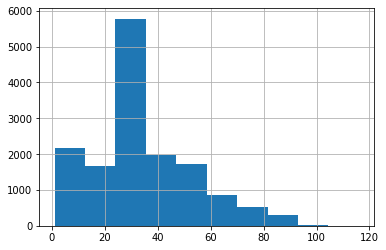

In [2]:
# load the datasets using the csv files train, val and test (3)
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
val = pd.read_csv('./data/val.csv')

# print the shapes of the dataframes (3)
print(train.shape)
print(test.shape)
print(val.shape)

# print the column names from either one of the dataframes (1)
print(train.columns.values)

num_ethnecities = train['ethnicity'].nunique()
print(num_ethnecities)

# print the proportional distribution of gender in all three datasets(i.e., number of male and female) (3)
print(f"Train Gender Distribution:\n{train['gender'].value_counts() / len(train)}\n")
print(f"Test Gender Distribution:\n{test['gender'].value_counts() / len(test)}\n")
print(f"Val Gender Distribution:\n{val['gender'].value_counts() / len(val)}\n")

# print the proportional distribution of ethnicity in all three datasets (3)
print(f"Train Ethnicity Distribution:\n{train['ethnicity'].value_counts() / len(train)}\n")
print(f"Test Eethnicity Distribution:\n{test['ethnicity'].value_counts() / len(test)}\n")
print(f"Val Eethnicity Distribution:\n{val['ethnicity'].value_counts() / len(val)}\n")

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis 
# depicts the count of individuals within each age group. For example, individuals with age=1 are: (2)
train['age'].hist()


#### Create the ImageDataGenerators (22/100)

Found 15026 validated image filenames.
Found 3757 validated image filenames.
Found 4696 validated image filenames.
39
4
0


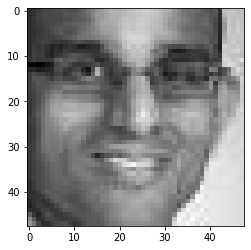

In [11]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size =11

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    dtype=None,
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
train_generator = train_img_gen.flow_from_dataframe(
  dataframe=train,
  directory='./data/images/train/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  seed = SEED,
  target_size=(48,48)
)

# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of the augmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
      rescale=1./255
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
val_generator = val_img_gen.flow_from_dataframe(
  dataframe=val,
  directory='./data/images/val/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  shuffle=False,
  seed = SEED,
  target_size=(48,48)
)


# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
test_img_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_img_gen.flow_from_dataframe(
  dataframe=test,
  directory='./data/images/test/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  shuffle=False,
  target_size=(48,48)
)


# enumerate through the validation data generator created above and plot first grayscale image 
# (2)
tmpx = enumerate(val_generator)
for i, element in tmpx:
    if i == 8:
      print(element[1][0][i])
      print(element[1][1][i])
      print(element[1][2][i])
      plt.imshow(element[0][i], cmap = 'gray')
      break

In [5]:
print(val_generator.image_shape)


(48, 48, 1)


#### Create the model (44/100)

In [12]:
# specify the model input with the required shape 
# (1)
in_shape = keras.Input(shape=(256, 256, 1))

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# TODO

leaky_relu = tf.keras.layers.LeakyReLU()
reg = tf.keras.regularizers.l2(l2=0.0001)

layer1 = tf.keras.layers.Conv2D(8, (3,3), name="layer1")
layer2 = tf.keras.layers.MaxPool2D(3,3, name="layer2")
layer3 = tf.keras.layers.Flatten(name="layer3")
layer4 = tf.keras.layers.Normalization(name="layer4")
layer5 = tf.keras.layers.Dropout(.5, name="layer5")
layer6 = tf.keras.layers.Dense(units=64, activation = tf.nn.relu, name="layer6")
layer7 = tf.keras.layers.Dense(units=64, activation = tf.nn.relu, name="layer7")
layer8 = tf.keras.layers.Dense(units=128, activation = tf.nn.relu, name="layer8")

sharedLayers = layer8(layer7(layer6(layer5(layer4(layer3((layer2(layer1(in_shape)))))))))

# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age
# TODO

ageTaskLayer = tf.keras.layers.Dense(units=256, activation= tf.nn.relu, name="ageTask")

# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task

ageLayer = tf.keras.layers.Dense(units=120, activation= tf.nn.softmax, name="age")
ageOutput = ageLayer(ageTaskLayer(sharedLayers))

# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction

ethTaskLayer = tf.keras.layers.Dense(units=256, activation= tf.nn.relu, name="ethTask")

# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task

ethLayer = tf.keras.layers.Dense(units=5, activation= tf.nn.sigmoid, name="eth")
ethOutput = ethLayer(ethTaskLayer(sharedLayers))

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction

genTaskLayer = tf.keras.layers.Dense(units=256, activation= tf.nn.relu, name="genTask")
tf.keras.optimizers.Adam()
# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task

genLayer = tf.keras.layers.Dense(units=2, activation= tf.nn.softmax, name="gen")
genOutput = genLayer(genTaskLayer(sharedLayers))

# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
# (3)

outputs = [ageOutput, ethOutput, genOutput]

model = tf.keras.Model(inputs = in_shape, outputs = outputs, name = "tmo")

# print the model summary
# (0.5)

print(model.summary())

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# (2)

optimizer = tf.keras.optimizers.Adam()

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)

losses = [
#age
tf.keras.losses.SparseCategoricalCrossentropy(),
#ethnicity
tf.keras.losses.SparseCategoricalCrossentropy(),
#gender
tf.keras.losses.SparseCategoricalCrossentropy()

]

# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# (2)

metrics = [
tf.keras.metrics.MeanAbsoluteError(), 
tf.keras.metrics.Accuracy(),
tf.keras.metrics.Accuracy()
]

model.compile(optimizer=optimizer,
              loss=losses,
              loss_weights=[0.001, 0.5, 0.5],
              metrics=['accuracy'])

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# (2)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint
# monitor validation loss and save the best model weights
# (2)



# Initiallize TensorBoard
# TODO
# (2)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# (2)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-5,
    verbose=1
)

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)

model.fit(
        train_generator,
        epochs=10,
)

Model: "tmo"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 layer1 (Conv2D)                (None, 47, 47, 4)    20          ['input_2[0][0]']                
                                                                                                  
 layer2 (MaxPooling2D)          (None, 23, 23, 4)    0           ['layer1[0][0]']                 
                                                                                                  
 layer3 (Flatten)               (None, 2116)         0           ['layer2[0][0]']                 
                                                                                                

In [13]:
# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# TODO
# (2)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
# optimizer = tf.keras.optimizers.SGD(lr=0.001)
# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)
losses = {'age': 'mean_squared_error', 'ethnicity': ['categorical_crossentropy'],'gender':['binary_crossentropy']}

# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# TODO
# (2)

# compile the model
model.compile(optimizer=optimizer,
              loss=tf.nn.softmax_cross_entropy_with_logits,
              loss_weights=[0.001, 0.5, 0.5],
              metrics={'age': 'accuracy', 'ethnicity': ['sparse_categorical_accuracy'],'gender':['binary_accuracy']}
              )

check_dir, tboard_dir = make_directories()

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# TODO
# (2)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint
# monitor validation loss and save the best model weights
# TODO
# (2)
checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Initiallize TensorBoard
# TODO
# (2)
tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# TODO
# (2)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

callbacks = [early_stop, checkpoints, tensorboard, reduce_lr]

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)

model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        batch_size=batch_size, 
        callbacks=callbacks,
        steps_per_epoch=len(train)/batch_size,
        validation_steps=len(val)/batch_size
)

Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 5.4491 - age_loss: 0.0000e+00 - ethnicity_loss: 10.2375 - gender_loss: 0.6608 - age_accuracy: 0.0000e+00 - ethnicity_sparse_categorical_accuracy: 0.0786 - gender_binary_accuracy: 0.4776

TypeError: Cannot convert 0.2500332756555304 to EagerTensor of dtype int64

#### Making predictions on test data (14/100)

In [8]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions (4)
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

47/47 [==============================] - 2s 43ms/step - loss: 5.4511 - age_loss: 0.0000e+00 - ethnicity_loss: 10.2410 - gender_loss: 0.6613 - age_accuracy: 0.0000e+00 - ethnicity_sparse_categorical_accuracy: 0.3778 - gender_binary_accuracy: 0.5230


{'loss': 5.4511308670043945,
 'age_loss': 0.0,
 'ethnicity_loss': 10.240997314453125,
 'gender_loss': 0.6612650752067566,
 'age_accuracy': 0.0,
 'ethnicity_sparse_categorical_accuracy': 0.37776830792427063,
 'gender_binary_accuracy': 0.5229982733726501}

In [9]:
# generate predictions using the test generator (2)
pred = model.predict(test_generator)
print(pred)

# extract the ethnicity predictions (2)
# print the classification report for predicting ethnicity (2)


# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
(2)
# print the classification report for predicting gender
(2)

[array([[0.01414664],
       [0.02321187],
       [0.0171011 ],
       ...,
       [0.02042973],
       [0.03173344],
       [0.02266643]], dtype=float32), array([[0.07431011, 0.04576685, 0.04780821, 0.03810893, 0.05392777],
       [0.07265443, 0.02199829, 0.05997241, 0.02930011, 0.06242132],
       [0.04812334, 0.04250259, 0.04807137, 0.03862368, 0.04535403],
       ...,
       [0.04073707, 0.02097819, 0.02908952, 0.02097313, 0.03325227],
       [0.07380683, 0.04240367, 0.06600414, 0.04362871, 0.05748645],
       [0.0645574 , 0.03532101, 0.04906441, 0.02966733, 0.05079977]],
      dtype=float32), array([[0.49293727, 0.49182233],
       [0.4947991 , 0.4934057 ],
       [0.4942014 , 0.4945852 ],
       ...,
       [0.4953664 , 0.49645782],
       [0.49137017, 0.49335498],
       [0.49334997, 0.49361444]], dtype=float32)]


2

In [10]:
# extract the ethnicity predictions (2)

print(pred[0][0])
print(pred[1][0])
print(pred[2][0])

print(test_generator[0][1:])
# print the classification report for predicting ethnicity (2)


[0.01414664]
[0.07431011 0.04576685 0.04780821 0.03810893 0.05392777]
[0.49293727 0.49182233]
([array([30,  1, 27, 28, 28, 38,  2, 42, 27, 23, 28, 66, 38, 72, 78, 26, 40,
       80, 36, 29, 65,  1, 79, 39, 28, 15, 28, 24,  1, 32, 57, 54, 29, 25,
        4, 46,  1, 15, 49,  4, 56, 32, 25, 25, 21, 16, 46, 44, 65, 63, 32,
       69, 16, 65, 25, 54, 51, 22, 21, 30, 53, 20, 90,  1, 26,  1, 19, 16,
       99,  3, 16, 65, 73,  1,  2, 34, 25, 28,  7, 27, 25,  1, 49, 52, 24,
       36,  8, 32, 60,  1, 22, 86, 22, 32, 47,  4, 16, 28, 36, 41]), array([2, 2, 1, 3, 2, 0, 4, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 4, 1, 3, 3,
       1, 0, 0, 0, 1, 2, 3, 0, 1, 0, 0, 3, 2, 3, 2, 3, 1, 2, 0, 1, 1, 1,
       1, 0, 3, 3, 2, 0, 4, 0, 0, 0, 3, 3, 1, 4, 1, 4, 0, 4, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 3, 0, 3, 0, 3, 2, 3, 0, 0, 0, 0, 4, 0, 0, 2,
       3, 0, 1, 0, 1, 0, 0, 2, 0, 1, 3, 3]), array([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1

#### Present prediction results on test data(5/100)

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy) |
|-----------------|----------|--------------------|------------------|
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
